# **1. Imports**

In [ ]:
# === Built-in Python libraries ===
import os
import json
import random
from datetime import datetime
from collections import Counter

# === Numerical and data handling ===
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# === PyTorch ===
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

# === TensorFlow / Keras ===
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

# === Evaluation metrics ===
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

# === External tools ===
import kagglehub
from google.colab import drive


# **2. Definitions**

## Evaluation functions

In [ ]:
def evaluate_detailed_metrics(model, dataset, batch_size=128):
    """Evaluate standard metrics and confusion matrix without tolerance."""
    y_true = []
    y_pred = []

    for i in range(0, len(dataset), batch_size):
        batch = []
        labels = []
        for j in range(i, min(i + batch_size, len(dataset))):
            image, label = dataset[j]
            image_np = image.numpy().transpose(1, 2, 0)  # (48, 48, 1)
            label_np = label.numpy().squeeze(0)  # (100,)
            batch.append(image_np)
            labels.append(np.argmax(label_np))  # true class index

        x_batch = np.array(batch).astype('float32')
        y_true.extend(labels)

        y_probs = model.predict(x_batch, verbose=0)
        y_pred.extend(np.argmax(y_probs, axis=1))

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    # MAE
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n Mean Absolute Error (MAE): {mae:.4f} (en unitats d'edat predita)")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(100))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap="Blues", xticklabels=10, yticklabels=10)
    plt.title("Confusion Matrix (first 10 classes visible)")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

#___________________________________________________________________________________________________________________________________________

# __________Tolerance accuracy COSTUMED

class ToleranceAccuracy(tf.keras.metrics.Metric):
    def __init__(self, tolerance=2, name='tolerance_accuracy', **kwargs):
        super(ToleranceAccuracy, self).__init__(name=name, **kwargs)
        self.tolerance = tolerance
        self.total_correct = self.add_weight(name='total_correct', initializer='zeros')
        self.total_samples = self.add_weight(name='total_samples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_indices = tf.argmax(y_true, axis=1)
        y_pred_indices = tf.argmax(y_pred, axis=1)
        diff = tf.abs(tf.cast(y_true_indices, tf.float32) - tf.cast(y_pred_indices, tf.float32))
        correct_within_tolerance = tf.reduce_sum(tf.cast(diff <= self.tolerance, tf.float32))
        self.total_correct.assign_add(correct_within_tolerance)
        self.total_samples.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        return self.total_correct / self.total_samples

    def reset_state(self):
        self.total_correct.assign(0.)
        self.total_samples.assign(0.)

#___________________________________________________________________________________________________________________________________________

def evaluate_detailed_metrics_tolerance(model, dataset, batch_size=128, tolerance=1):
    """Evaluate classification performance using a tolerance margin."""

    y_true = []
    y_pred = []

    # Generate predictions and true labels batch by batch
    for i in range(0, len(dataset), batch_size):
        batch = []
        labels = []

        for j in range(i, min(i + batch_size, len(dataset))):
            image, label = dataset[j]
            image_np = image.numpy().transpose(1, 2, 0)  # Convert to shape (48, 48, 1)
            label_np = label.numpy().squeeze(0)          # Convert to shape (100,)
            batch.append(image_np)
            labels.append(np.argmax(label_np))           # True class index

        x_batch = np.array(batch).astype('float32')
        y_true.extend(labels)

        y_probs = model.predict(x_batch, verbose=0)
        y_pred.extend(np.argmax(y_probs, axis=1))

    # Create tolerant predictions (keep prediction only if within ±tolerance)
    y_pred_tolerant = [
        true if abs(true - pred) <= tolerance else pred
        for true, pred in zip(y_true, y_pred)
    ]

    # Classification report using tolerant predictions
    print("\nClassification Report (with tolerance):")
    print(classification_report(y_true, y_pred_tolerant, zero_division=0))

    # Mean Absolute Error (using tolerant predictions)
    mae = mean_absolute_error(y_true, y_pred_tolerant)
    print(f"\nMean Absolute Error (MAE with tolerance): {mae:.4f} (in predicted age units)")

    # Tolerant Accuracy: how many predictions fall within ±tolerance range
    correct_with_tolerance = sum(
        abs(t - p) <= tolerance for t, p in zip(y_true, y_pred)
    )
    tolerant_accuracy = correct_with_tolerance / len(y_true)
    print(f"\nTolerant Accuracy (±{tolerance} years): {tolerant_accuracy:.4f}")

    # Confusion matrix using standard (non-tolerant) predictions
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(100))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, cmap="Blues", xticklabels=10, yticklabels=10)
    plt.title("Confusion Matrix (no tolerance, first 10 classes shown)")
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

#___________________________________________________________________________________________________________________________________________

def evaluate_tolerance_accuracy(model, val_gen, tolerances=[0, 1, 2, 3, 5]):
    """
    Evaluate model accuracy under different tolerance levels using one-hot encoded labels.
    """

    all_y_true = []
    all_y_pred = []

    # Accumulate predictions and true labels across all batches
    for x_batch, y_batch in val_gen:
        preds = model.predict(x_batch, verbose=0)
        all_y_true.append(y_batch)
        all_y_pred.append(preds)

    # Concatenate all batches into single arrays
    y_true = np.concatenate(all_y_true, axis=0)
    y_pred = np.concatenate(all_y_pred, axis=0)

    # Print accuracy for each tolerance value
    print("\nAccuracy by tolerance level:")
    for tol in tolerances:
        metric = ToleranceAccuracy(tolerance=tol)
        metric.update_state(y_true, y_pred)
        acc = metric.result().numpy()
        print(f"  ±{tol} years → Accuracy: {acc * 100:.2f}%")


## Ploting Datasets

In [ ]:
def plot_class_distribution(dataset, title="Class distribution (ages)"):
    """
    Plot the distribution of samples per class (age) in the dataset.

    Parameters:
        dataset (torch.utils.data.Dataset): Dataset containing image-label pairs.
        title (str): Title for the plot.
    """
    labels = []

    # Extract class indices from one-hot encoded labels
    for _, label_tensor in dataset:
        class_index = label_tensor.squeeze(0).argmax().item()
        labels.append(class_index)

    # Count frequency of each class
    counts = Counter(labels)
    classes = list(range(100))
    frequencies = [counts.get(i, 0) for i in classes]

    # Create bar plot
    plt.figure(figsize=(14, 5))
    plt.bar(classes, frequencies, color='cornflowerblue')
    plt.title(title)
    plt.xlabel("Age (class index)")
    plt.ylabel("Number of images")
    plt.xticks(range(0, 100, 5))
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

#___________________________________________________________________________________________________________________________________________

def plot_age_boxplot(dataset, title="Boxplot of Age Distribution in UTKFace Dataset"):
    """
    Plot a boxplot to visualize the age distribution in the dataset based on image filenames.

    Parameters:
        dataset (Custom Dataset): Dataset object containing an 'image_files' attribute with filenames.
        title (str): Title of the plot.
    """
    ages = []

    # Extract age from filename prefix (assumes filename starts with the age)
    for i in range(len(dataset)):
        filename = dataset.image_files[i]
        try:
            age = int(filename.split('_')[0])
            if 0 <= age < 100:
                ages.append(age)
        except:
            continue

    # Create DataFrame for visualization
    df_ages = pd.DataFrame(ages, columns=['Age'])

    # Plot the boxplot
    plt.figure(figsize=(12, 4))
    sns.boxplot(x='Age', data=df_ages, color='skyblue')
    plt.title(title)
    plt.xlabel("Age")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Dataset balancing + grouping

In [ ]:
def group_images_by_age(image_dir, files):
    """
    Groups image filenames by age extracted from their filename prefix.

    Parameters:
        image_dir: directory containing the image files (not used here but kept for compatibility)
        files: list of filenames (expected format: 'age_gender_race...jpg')

    Returns:
        Dictionary {age: [list of filenames corresponding to that age]}
    """
    grouped = {}
    for f in files:
        try:
            age = int(f.split('_')[0])
            if 0 <= age < 100:
                if age not in grouped:
                    grouped[age] = []
                grouped[age].append(f)
        except:
            continue
    return grouped
#___________________________________________________________________________________________________________________________________________

def balance_augmentation(image_dir, grouped_files_by_age, max_images_per_age=700):
    """
    Balances the dataset by limiting or augmenting the number of images per age group.

    Parameters:
        image_dir: directory containing the images (not used inside the function)
        grouped_files_by_age: dictionary {age: [list of filenames]}
        max_images_per_age: target number of images per age group

    Returns:
        List of image filenames after balancing the dataset by age
    """
    balanced_files = []

    for age, files in grouped_files_by_age.items():
        num_files = len(files)

        if num_files >= max_images_per_age:
            selected_files = random.sample(files, max_images_per_age)
        else:
            repeat_factor = max_images_per_age // num_files
            remainder = max_images_per_age % num_files
            selected_files = files * repeat_factor + random.sample(files, remainder)

        balanced_files.extend(selected_files)

    random.shuffle(balanced_files)
    return balanced_files


## Saving function

In [ ]:
def save_training_checkpoint(model, history=None, save_dir="/content/drive/Shareddrives/deep learning/FACIAL_EMOTION_RECOGNITION/PROJECTE_COLLAB/training_checkpoints", filename="model", note=""):
    """Saves model weights, training summary (optional), and plot to a timestamped folder."""

    os.makedirs(save_dir, exist_ok=True)

    # Create timestamped folder name
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    base_name = f"{timestamp}_{filename}"
    run_dir = os.path.join(save_dir, base_name)
    os.makedirs(run_dir, exist_ok=True)

    # 1. Save model weights
    weights_path = os.path.join(run_dir, "weights.weights.h5")
    model.save_weights(weights_path)

    # 2. Prepare summary dictionary
    summary_data = {
        "timestamp": timestamp,
        "filename": filename,
        "note": note,
        "weights_file": weights_path
    }

    # 3. Save training history if available
    if history is not None:
        last_epoch = len(history.history['accuracy']) - 1
        summary_data.update({
            "epochs": len(history.history['accuracy']),
            "final_train_accuracy": float(history.history['accuracy'][last_epoch]),
            "final_val_accuracy": float(history.history['val_accuracy'][last_epoch]),
            "final_train_loss": float(history.history['loss'][last_epoch]),
            "final_val_loss": float(history.history['val_loss'][last_epoch]),
            "best_val_accuracy": float(max(history.history['val_accuracy']))
        })

        # Save per-epoch training data
        epoch_data = []
        for epoch in range(len(history.history['accuracy'])):
            epoch_data.append({
                "epoch": epoch + 1,
                "train_accuracy": float(history.history['accuracy'][epoch]),
                "val_accuracy": float(history.history['val_accuracy'][epoch]),
                "train_loss": float(history.history['loss'][epoch]),
                "val_loss": float(history.history['val_loss'][epoch])
            })
        summary_data["epoch_data"] = epoch_data

        # Save accuracy/loss plot
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(history.history['accuracy'], label='Train Accuracy')
        ax.plot(history.history['val_accuracy'], label='Val Accuracy')
        ax.plot(history.history['loss'], '--', label='Train Loss')
        ax.plot(history.history['val_loss'], '--', label='Val Loss')
        ax.set_title('Training History')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)
        plot_path = os.path.join(run_dir, "plot.png")
        plt.savefig(plot_path)
        plt.close()
        summary_data["plot_file"] = plot_path

    # 4. Save summary JSON
    summary_path = os.path.join(run_dir, "summary.json")
    with open(summary_path, "w") as f:
        json.dump(summary_data, f, indent=4)

    # 5. Confirmation message
    print(f"Files saved in: {run_dir}")
    print(f"  - Weights: {weights_path}")
    print(f"  - Summary JSON: {summary_path}")
    if history is not None:
        print(f"  - Plot: {plot_path}")



## Dataset adaptaion

In [ ]:
class TorchDatasetToKeras(tf.keras.utils.Sequence):
    """
    Wrapper to convert a PyTorch-style dataset into a Keras-compatible data generator.
    """
    def __init__(self, torch_dataset, batch_size=32):
        self.dataset = torch_dataset
        self.batch_size = batch_size

    def __len__(self):
        # Return the number of batches per epoch
        return len(self.dataset) // self.batch_size

    def __getitem__(self, idx):
        # Retrieve a batch of data
        batch_images = []
        batch_labels = []

        for i in range(self.batch_size):
            image, label = self.dataset[idx * self.batch_size + i]
            batch_images.append(image.numpy())          # Shape: (1, 48, 48)
            batch_labels.append(label.numpy()[0])       # Shape: (100,)

        # Convert to TensorFlow tensors and adjust dimensions
        batch_images = tf.convert_to_tensor(batch_images)             # Shape: (batch, 1, 48, 48)
        batch_images = tf.transpose(batch_images, perm=[0, 2, 3, 1])  # Shape: (batch, 48, 48, 1)
        batch_labels = tf.convert_to_tensor(batch_labels)             # Shape: (batch, 100)

        return batch_images, batch_labels


# **3. Dataset Uploading**

In [ ]:
# === COMMON CELL: Shared definitions and imports ===

# Dataset class for UTKFace images
class UTKFaceDataset(Dataset):
    def __init__(self, image_dir, image_files, transform=None):
        self.image_dir = image_dir
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        age = int(img_name.split('_')[0])
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = torch.zeros(1, 100)
        if age < 100:
            label[0, age] = 1.0

        return image, label


# Base and augmented transforms
base_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

#JUST FOR AUGMENTATION
augmented_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

# Download dataset using KaggleHub
path = kagglehub.dataset_download("jangedoo/utkface-new")
image_dir = os.path.join(path, "utkface_aligned_cropped/UTKFace")
files = os.listdir(image_dir)
print("Total images:", len(files))
print("Example filename:", files[0])


Total images: 23708
Example filename: 26_0_2_20170104023102422.jpg.chip.jpg


#3.1.Without data augmentation

In [ ]:
# === Dataset preparation without data augmentation ===

# Load all valid image filenames (ages between 0 and 99)
valid_files = []
for f in os.listdir(image_dir):
    if f.endswith('.jpg'):
        try:
            age = int(f.split('_')[0])
            if 0 <= age < 100:
                valid_files.append(f)
        except:
            continue

# Shuffle and split into train/val/test sets
random.shuffle(valid_files)
total = len(valid_files)
train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size

train_files = valid_files[:train_size]
val_files = valid_files[train_size:train_size + val_size]
test_files = valid_files[train_size + val_size:]

# Create datasets (no augmentation, just basic transform)
train_dataset = UTKFaceDataset(image_dir, train_files, transform=base_transform)
val_dataset   = UTKFaceDataset(image_dir, val_files, transform=base_transform)
test_dataset  = UTKFaceDataset(image_dir, test_files, transform=base_transform)

# Create Keras-style generators for training
train_gen = TorchDatasetToKeras(train_dataset, batch_size=32)
val_gen   = TorchDatasetToKeras(val_dataset, batch_size=32)
test_gen  = TorchDatasetToKeras(test_dataset, batch_size=32)


#3.2. With data augmentation

In [ ]:
# === Dataset preparation WITH data augmentation ===

#  Apply grouped splitting by age
train_grouped = {}
val_grouped = {}
test_grouped = {}

grouped_files_dict = group_images_by_age(image_dir, files)


for age, age_files in grouped_files_dict.items():
    random.shuffle(age_files)
    total = len(age_files)
    train_split = int(0.7 * total)
    val_split = int(0.15 * total)
    test_split = total - train_split - val_split

    train_grouped[age] = age_files[:train_split]
    val_grouped[age] = age_files[train_split:train_split + val_split]
    test_grouped[age] = age_files[train_split + val_split:]

# Balance training data (limited augmentation)
balanced_train_files = balance_augmentation(image_dir, train_grouped, max_images_per_age=300)

# Flatten file lists
train_files = balanced_train_files
val_files = [f for age_files in val_grouped.values() for f in age_files]
test_files = [f for age_files in test_grouped.values() for f in age_files]

# Create datasets with appropriate transforms
train_dataset = UTKFaceDataset(image_dir, train_files, transform=augmented_transform)  #AUGMENTATION
val_dataset   = UTKFaceDataset(image_dir, val_files, transform=base_transform)
test_dataset  = UTKFaceDataset(image_dir, test_files, transform=base_transform)

# Create Keras generators from the Torch datasets
train_gen = TorchDatasetToKeras(train_dataset, batch_size=32)
val_gen = TorchDatasetToKeras(val_dataset, batch_size=32)
test_gen = TorchDatasetToKeras(test_dataset, batch_size=32)


#**4. Data analysis**

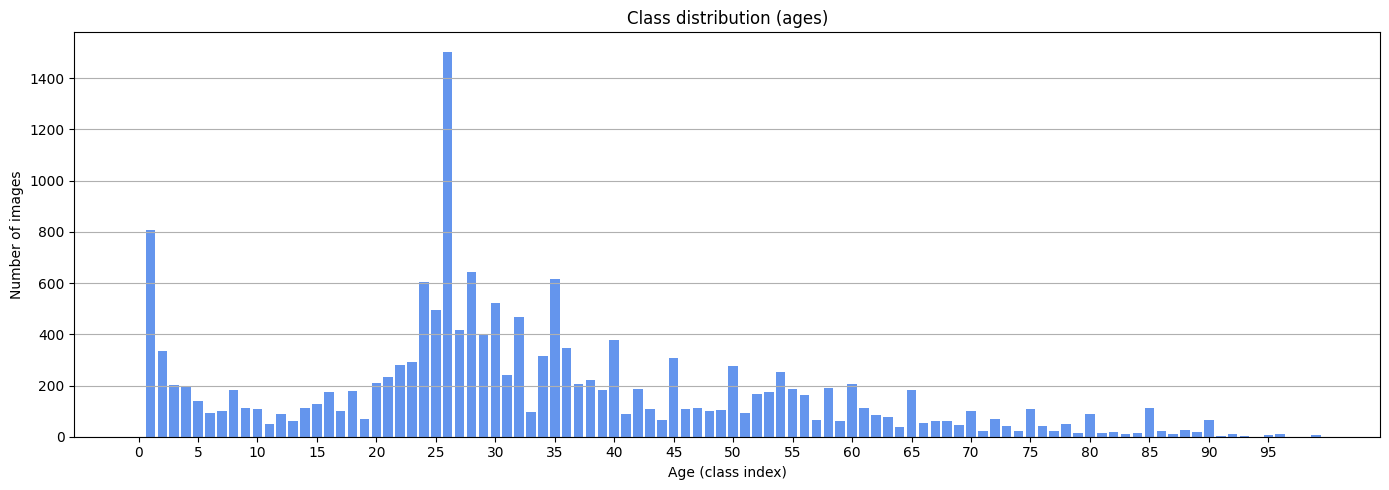

In [ ]:
plot_class_distribution(train_dataset)

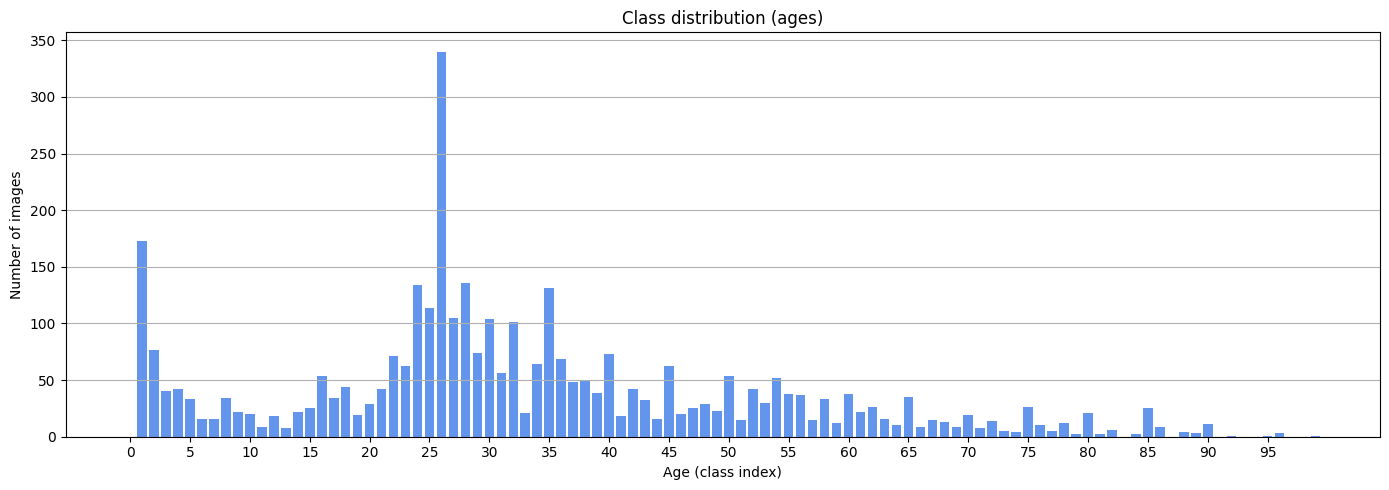

In [ ]:
plot_class_distribution(val_dataset)

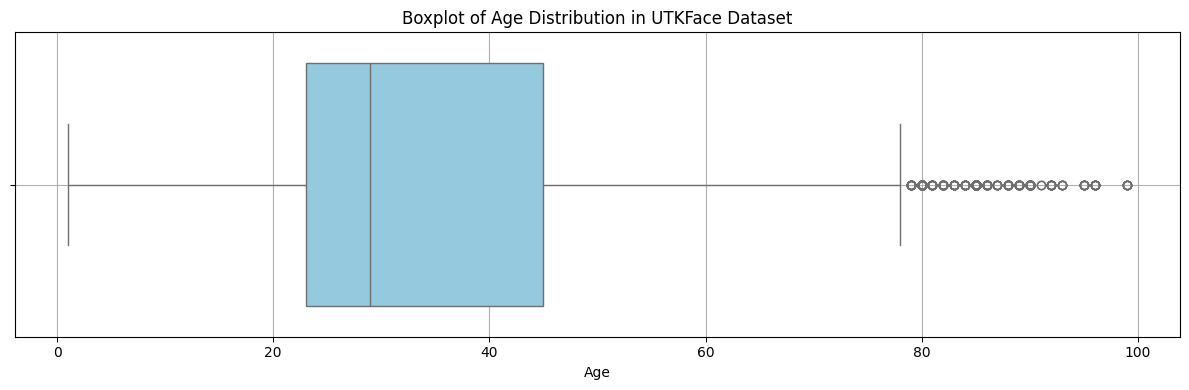

In [ ]:
plot_age_boxplot(train_dataset)

# **5. MODEL DEFINITONS**

#5.1. CHOSE THE WEIGHTS TO LOAD (maybe first part needs to be changed)

In [ ]:
# Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Best weights from the ORIGINAL CNN

In [ ]:
weights_path = "/content/drive/MyDrive/FACIAL AGE CLASSIFICATION/CODE/RESULTS/100_outputs/Original CNN/1st convolutional block and the first two layers of the 2nd block remain frozen/Second Phase/weights.weights.h5"

### Best weights from the ORIGINAL + 1FC

In [ ]:
weights_path = "/content/drive/MyDrive/FACIAL AGE CLASSIFICATION/CODE/RESULTS/100_outputs/Original CNN + 1FC/Second Phase/weights.weights.h5"

## Best weights from the ORIGINAL + 1FC DATA AUGMENTATION

In [ ]:
weights_path = "/content/drive/MyDrive/FACIAL AGE CLASSIFICATION/CODE/RESULTS/100_outputs/Original CNN + 1FC/Data augmentation (Second Phase)/weights.weights.h5"

### Best weights from the ORIGINAL + 2FC

In [ ]:
weights_path = "/content/drive/MyDrive/FACIAL AGE CLASSIFICATION/CODE/RESULTS/100_outputs/Original CNN + 2FC/Second Phase/weights.weights.h5"

#5.1.1. ORIGINAL CNN -> ADDAPTING THE OUTPUTS

In [ ]:
# Original model for age prediction with 100 output classes (ages 0–99)
model = Sequential([
    # First convolutional block
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Second convolutional block
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Third convolutional block
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fully connected layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer for 100 classes (one-hot encoded ages)
    Dense(100, activation='softmax')
])

# Compile the model with categorical crossentropy for multi-class classification
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Load pre-trained weights
# 'skip_mismatch=True' allows loading only compatible layers (ignoring output mismatch)
model.load_weights(weights_path, skip_mismatch=False)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,418,084 (5.41 MB)

 Trainable params: 1,415,844 (5.40 MB)

 Non-trainable params: 2,240 (8.75 KB)

#5.1.2. ADDING 1 FC

In [ ]:
model = Sequential([

    # Convolutional Block 1
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Convolutional Block 2
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Convolutional Block 3
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),

    # Newly added dense layer to increase classifier capacity
    Dense(512, activation='relu'),       # NEW
    BatchNormalization(),                # NEW
    Dropout(0.5),                        # NEW

    # Previous FC layer
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Final output layer with 100 age classes (softmax)
    Dense(100, activation='softmax')
])

# Compile the model for categorical classification
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Load existing weights
model.load_weights(weights_path, skip_mismatch=False)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_88          │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_89          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_90          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_91          │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_92          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,813,860 (6.92 MB)

 Trainable params: 1,810,596 (6.91 MB)

 Non-trainable params: 3,264 (12.75 KB)

#5.1.3. ADDING 2 FC

In [ ]:
model = Sequential([

    # Convolutional Block 1
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Convolutional Block 2
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Convolutional Block 3
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(256, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Fully Connected Layers
    Flatten(),

    # First added fully connected layer (new)
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),


    # Second added fully connected layer (new)
    Dense(384, activation='relu'),           #NEW
    BatchNormalization(),                    #NEW
    Dropout(0.5),                            #NEW

    # First original fully connected layer
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output layer with 100 classes
    Dense(100, activation='softmax')
])

# Compile the model
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Load existing weights
model.load_weights(weights_path, skip_mismatch=False)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_54 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_69          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_70          │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_71          │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_72          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,979,620 (7.55 MB)

 Trainable params: 1,975,588 (7.54 MB)

 Non-trainable params: 4,032 (15.75 KB)

# **6. Training Methodology: Transfer Learning with Two-Phase Fine-Tuning**

The training was carried out in two distinct phases to take advantage of transfer learning while ensuring the model converges smoothly.

But each phase was repeated as many times as necessary until the model converged.


OUR TRAINING PROCES CAN BE SEEN IN THE RESULTS FOLDER

## Fine-tuning: Freezing

In [ ]:
# Freeze all layers except the output layer
for layer in model.layers[:-1]:
    layer.trainable = False

# Unfreeze the last 18 layers (including dense classifier)
for layer in model.layers[-18:]:
    layer.trainable = True

# Print layer-wise trainability status
for i, layer in enumerate(model.layers):
    status = "Trainable" if layer.trainable else "Frozen"
    print(f"{i:2d} - {layer.name:30s} - {status}")


## Phase 1: Initial Fine-Tuning with Moderate Learning Rate

In [ ]:
# Compile the model with a modeerate learning rate
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[
        'accuracy',                          # Standard top-1 accuracy
        ToleranceAccuracy(tolerance=1)       # Custom metric: counts prediction as correct if within ±1 class
    ]
)


history = model.fit(train_gen, validation_data=val_gen, epochs=10)

## Phase 2: Final Fine-Tuning with Low Learning Rate

This stage helps the model converge to a better local minimum by refining its predictions

In [ ]:
# Compile the model with a very low learning rate
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=[
        'accuracy',                          # Standard top-1 accuracy
        ToleranceAccuracy(tolerance=1)       # Custom metric: counts prediction as correct if within ±1 class
    ]
)


history = model.fit(train_gen, validation_data=val_gen, epochs=35)

##Saving the weigths

In [ ]:
save_training_checkpoint(
    model,
    history,
    save_dir="/content/drive/Shareddrives/deep learning/FACIAL AGE CLASSIFICATION/CODE/RESULTS/100_outputs",
    filename="example",
    note=""
)

✔️ Fitxers guardats a: /content/drive/Shareddrives/deep learning/FACIAL_EMOTION_RECOGNITION/PROJECTE_COLLAB/training_checkpoints/2025-05-30_18-47-42_dataaugm_100output
  - Pesos: /content/drive/Shareddrives/deep learning/FACIAL_EMOTION_RECOGNITION/PROJECTE_COLLAB/training_checkpoints/2025-05-30_18-47-42_dataaugm_100output/weights.weights.h5
  - JSON : /content/drive/Shareddrives/deep learning/FACIAL_EMOTION_RECOGNITION/PROJECTE_COLLAB/training_checkpoints/2025-05-30_18-47-42_dataaugm_100output/summary.json
  - Gràfic: /content/drive/Shareddrives/deep learning/FACIAL_EMOTION_RECOGNITION/PROJECTE_COLLAB/training_checkpoints/2025-05-30_18-47-42_dataaugm_100output/plot.png


#**7. Evaluation on testing**

## With best weights from the ORIGINAL

In [ ]:
evaluate_tolerance_accuracy(model, test_gen, tolerances=[0, 1, 2, 3, 5])


Accuracy by tolerance level:
  ±0 years → Accuracy: 29.65%
  ±1 years → Accuracy: 41.72%
  ±2 years → Accuracy: 51.66%
  ±3 years → Accuracy: 59.49%
  ±5 years → Accuracy: 72.35%



Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.95      0.83       155
           2       0.50      0.34      0.40        77
           3       0.38      0.15      0.21        40
           4       0.42      0.65      0.51        34
           5       0.38      0.35      0.37        31
           6       0.44      0.33      0.38        12
           7       0.60      0.13      0.21        23
           8       0.36      0.57      0.44        40
           9       0.44      0.58      0.50        24
          10       0.63      0.39      0.48        31
          11       0.50      0.17      0.25         6
          12       0.44      0.29      0.35        24
          13       1.00      0.10      0.18        10
          14       0.12      0.19      0.15        16
          15       0.67      0.26      0.37        31
          16       0.37      0.52      0.43        33
          17       0.21      0.17      0.19        18
   

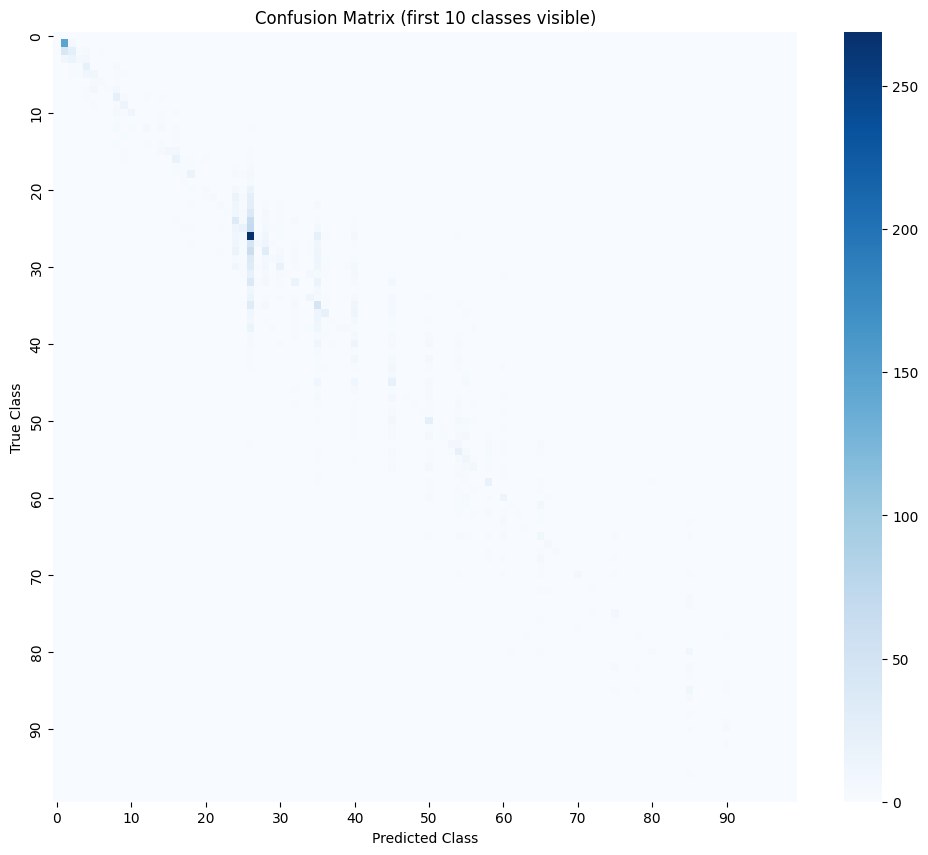

In [ ]:
evaluate_detailed_metrics(model, test_dataset)

## With best weights from the ORIGINAL + 1FC

In [ ]:
evaluate_tolerance_accuracy(model, test_gen, tolerances=[0, 1, 2, 3, 5])


Accuracy by tolerance level:
  ±0 years → Accuracy: 56.87%
  ±1 years → Accuracy: 65.65%
  ±2 years → Accuracy: 71.82%
  ±3 years → Accuracy: 76.77%
  ±5 years → Accuracy: 85.08%



Classification Report:
              precision    recall  f1-score   support

           1       0.85      0.94      0.90       155
           2       0.71      0.64      0.67        77
           3       0.77      0.57      0.66        40
           4       0.53      0.59      0.56        34
           5       0.73      0.71      0.72        31
           6       0.67      0.33      0.44        12
           7       0.77      0.74      0.76        23
           8       0.42      0.50      0.45        40
           9       0.55      0.75      0.63        24
          10       0.64      0.45      0.53        31
          11       0.00      0.00      0.00         6
          12       0.67      0.50      0.57        24
          13       0.67      0.20      0.31        10
          14       0.40      0.62      0.49        16
          15       0.62      0.48      0.55        31
          16       0.54      0.82      0.65        33
          17       0.62      0.44      0.52        18
   

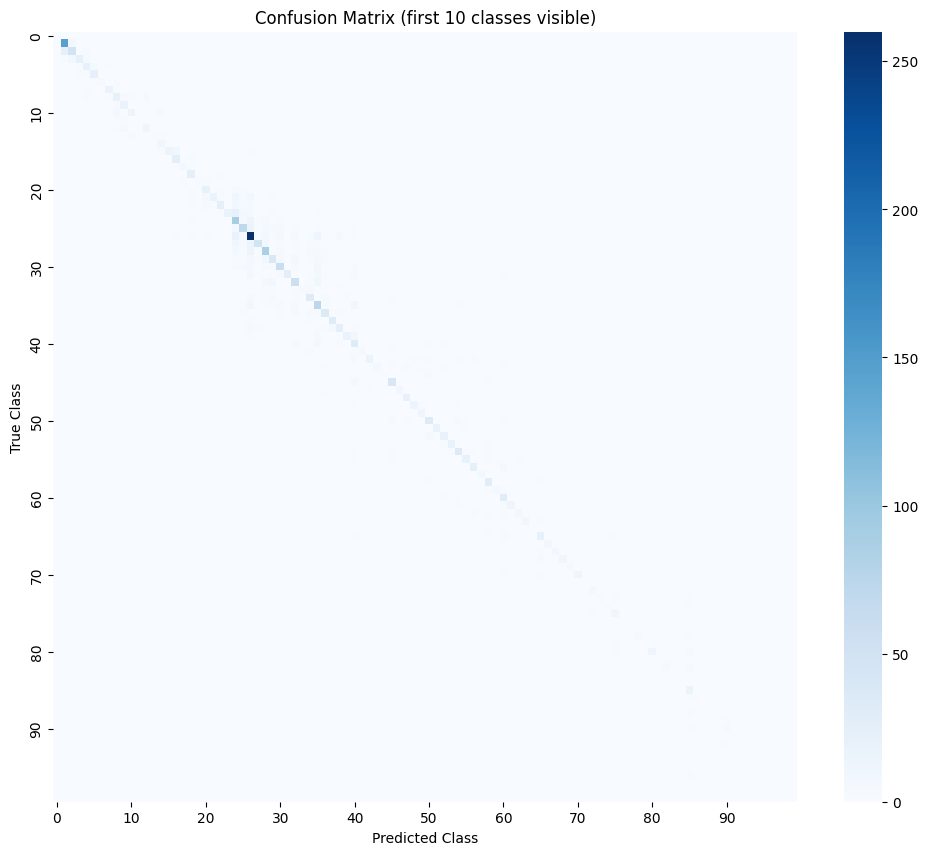

In [ ]:
evaluate_detailed_metrics(model, test_dataset)


Classification Report (with tolerance):
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       169
           2       1.00      1.00      1.00        81
           3       0.98      1.00      0.99        41
           4       1.00      0.95      0.97        41
           5       1.00      0.89      0.94        28
           6       1.00      1.00      1.00        18
           7       1.00      0.94      0.97        16
           8       0.82      0.88      0.85        41
           9       0.95      0.95      0.95        21
          10       0.90      0.79      0.84        33
          11       1.00      0.92      0.96        13
          12       0.86      0.86      0.86        14
          13       1.00      0.94      0.97        17
          14       0.85      0.79      0.82        29
          15       0.90      0.84      0.87        31
          16       0.79      0.81      0.80        32
          17       0.84      0.89      0

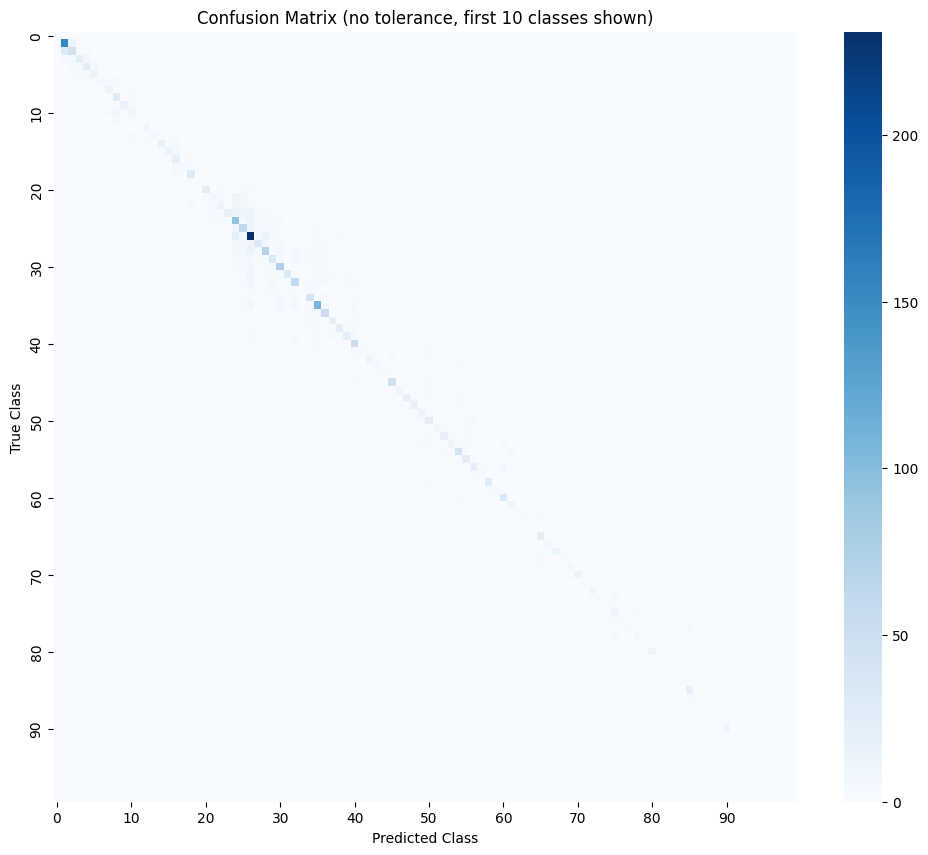

In [ ]:
evaluate_detailed_metrics_tolerance(model, test_dataset, batch_size=128, tolerance=3)

## With best weights from the ORIGINAL + 1FC DATA AUGMENTATION

In [ ]:
evaluate_tolerance_accuracy(model, test_gen, tolerances=[0, 1, 2, 3, 5])


Accuracy by tolerance level:
  ±0 years → Accuracy: 12.67%
  ±1 years → Accuracy: 23.76%
  ±2 years → Accuracy: 34.43%
  ±3 years → Accuracy: 42.15%
  ±5 years → Accuracy: 53.90%



Classification Report:
              precision    recall  f1-score   support

           1       0.69      0.80      0.74       169
           2       0.32      0.14      0.19        73
           3       0.07      0.05      0.05        44
           4       0.28      0.31      0.29        42
           5       0.18      0.23      0.21        30
           6       0.12      0.14      0.13        21
           7       0.12      0.18      0.15        22
           8       0.29      0.05      0.09        40
           9       0.12      0.15      0.14        26
          10       0.08      0.04      0.05        24
          11       0.11      0.73      0.20        11
          12       0.00      0.00      0.00        20
          13       0.09      0.15      0.11        13
          14       0.06      0.08      0.07        25
          15       0.06      0.36      0.10        28
          16       0.06      0.05      0.06        38
          17       0.06      0.20      0.10        25
   

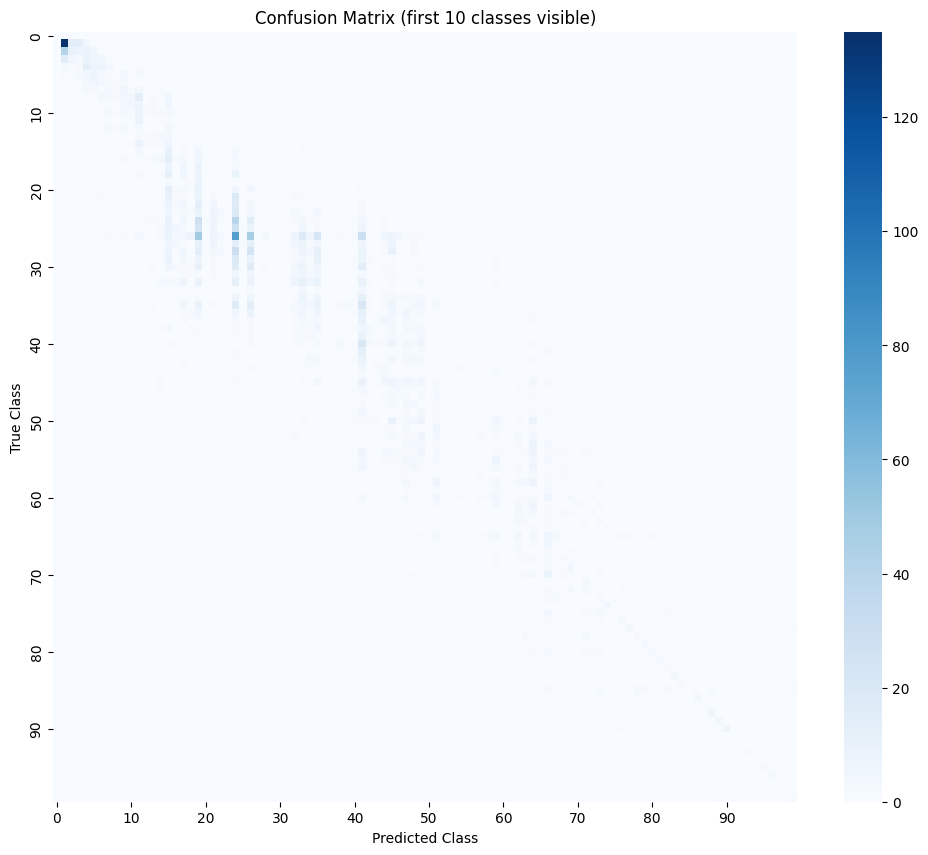

In [ ]:
evaluate_detailed_metrics(model, test_dataset)